# Import the Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Data Gathered By Me Via the MyAnimeList API and Jikan REST API
anime_df = pd.read_csv('./data/anime.csv')
user_ratings_df = pd.read_csv('./data/user_ratings.csv', parse_dates=['updated_at'])

In [3]:
anime_df.head()

,id,title,start_date,end_date,synopsis,score,rank,popularity,num_list_users,num_scoring_users,media_type,status,genres,num_episodes,start_season,broadcast_day,broadcast_time,source,rating,studios
0,5114,Fullmetal Alchemist: Brotherhood,2009-04-05,2010-07-04,After a horrific alchemy experiment goes wrong...,9.10,1.0,3,3240265,2056814,tv,finished_airing,"Action,Adventure,Drama,Fantasy,Military,Shounen",64,spring,sunday,17:00,manga,r,Bones
1,9253,Steins;Gate,2011-04-06,2011-09-14,Eccentric scientist Rintarou Okabe has a never...,9.07,2.0,13,2489957,1361494,tv,finished_airing,"Drama,Psychological,Sci-Fi,Suspense,Time Travel",24,spring,wednesday,02:05,visual_novel,pg_13,White Fox
2,28977,Gintama°,2015-04-08,2016-03-30,"Gintoki, Shinpachi, and Kagura return as the f...",9.06,3.0,336,610158,243298,tv,finished_airing,"Action,Comedy,Gag Humor,Historical,Parody,Samu...",51,spring,wednesday,18:00,manga,pg_13,Bandai Namco Pictures
3,41467,Bleach: Sennen Kessen-hen,2022-10-11,2022-12-27,Substitute Soul Reaper Ichigo Kurosaki spends ...,9.05,4.0,432,489199,245969,tv,finished_airing,"Action,Adventure,Fantasy,Shounen",13,fall,tuesday,00:00,manga,r,Pierrot
4,39486,Gintama: The Final,2021-01-08,2021-01-08,Two years have passed following the Tendoshuu'...,9.05,5.0,1550,140032,67119,movie,finished_airing,"Action,Comedy,Drama,Gag Humor,Historical,Parod...",1,winter,NaN,NaN,manga,pg_13,Bandai Namco Pictures


In [4]:
user_ratings_df.drop(columns=['start_date', 'finish_date'], inplace=True)

# Handle Per-Processing on the Standard Dataset

In [5]:
user_ratings_df.isna().sum()

user_id                 0
anime_id                0
score                   0
status                  1
num_episodes_watched    0
updated_at              0
dtype: int64

Although the above functions shows that there are no missing score values, a score of 0 indicates that the score was missing since it's not possible on MyAnimeList to rate an anime 0 unless you choose not to rate the anime.

## Remove Users who have only given scores of 0

In [6]:
users_to_remove = []
for user_id in user_ratings_df.user_id.unique():
  users_ratings = user_ratings_df.loc[user_ratings_df.user_id == user_id]
  num_non_zero_scores = len(users_ratings.loc[users_ratings.score > 0])

  if num_non_zero_scores == 0:
    users_to_remove.append(user_id)

print(users_to_remove)

[20, 35, 40, 57, 88, 116, 122, 124, 127, 131, 137, 139, 148, 185, 198, 202, 210, 217, 225, 226, 229, 232, 234, 235, 253, 271, 308, 309, 315, 321, 322, 364, 376, 384, 385, 387, 393, 419, 426, 443, 462, 476, 479, 487, 504, 506, 516, 532, 559, 562, 564, 569, 570, 590, 599, 612, 615, 617, 626, 644, 660, 664, 691, 723, 732, 733, 741, 745, 751, 761, 763, 766, 770, 771, 776, 785, 788, 794, 804, 815, 816, 844, 853, 860, 868, 879, 883, 886, 890, 897, 898, 906, 926, 961, 992, 999, 1023, 1029, 1033, 1054, 1059, 1065, 1077, 1090, 1099, 1105, 1108, 1114, 1127, 1129, 1143, 1145, 1147, 1156, 1157, 1170, 1180, 1223, 1227, 1228, 1230, 1237, 1258, 1268, 1271, 1272, 1273, 1310, 1314, 1351, 1358, 1370, 1386, 1387, 1388, 1392, 1406, 1409, 1420, 1427, 1446, 1455, 1458, 1469, 1477, 1490, 1491, 1511, 1522, 1529, 1541, 1542, 1549, 1557, 1570, 1576, 1587, 1594, 1596, 1604, 1607, 1616, 1641, 1650, 1652, 1653, 1655, 1662, 1667, 1691, 1693, 1715, 1720, 1732, 1746, 1752, 1755, 1764, 1766, 1795, 1806, 1808, 1840, 18

In [7]:
user_ratings_df = user_ratings_df.loc[~user_ratings_df.user_id.isin(users_to_remove)]

### Remove Shows without the Completed Status

In [8]:
user_ratings_df = user_ratings_df.loc[user_ratings_df.status == 'completed']

### Remove Users with Less than 15 Ratings

In [9]:
users_not_enough_ratings = []
num_minimum_ratings = 15

# Find the users
for user_id in user_ratings_df.user_id.unique():
    if (len(user_ratings_df.loc[user_ratings_df.user_id == user_id]) < num_minimum_ratings):
        users_not_enough_ratings.append(user_id)

# Remove the users
user_ratings_df = user_ratings_df.loc[~user_ratings_df.user_id.isin(users_not_enough_ratings)]

In [10]:
print(users_to_remove)

[20, 35, 40, 57, 88, 116, 122, 124, 127, 131, 137, 139, 148, 185, 198, 202, 210, 217, 225, 226, 229, 232, 234, 235, 253, 271, 308, 309, 315, 321, 322, 364, 376, 384, 385, 387, 393, 419, 426, 443, 462, 476, 479, 487, 504, 506, 516, 532, 559, 562, 564, 569, 570, 590, 599, 612, 615, 617, 626, 644, 660, 664, 691, 723, 732, 733, 741, 745, 751, 761, 763, 766, 770, 771, 776, 785, 788, 794, 804, 815, 816, 844, 853, 860, 868, 879, 883, 886, 890, 897, 898, 906, 926, 961, 992, 999, 1023, 1029, 1033, 1054, 1059, 1065, 1077, 1090, 1099, 1105, 1108, 1114, 1127, 1129, 1143, 1145, 1147, 1156, 1157, 1170, 1180, 1223, 1227, 1228, 1230, 1237, 1258, 1268, 1271, 1272, 1273, 1310, 1314, 1351, 1358, 1370, 1386, 1387, 1388, 1392, 1406, 1409, 1420, 1427, 1446, 1455, 1458, 1469, 1477, 1490, 1491, 1511, 1522, 1529, 1541, 1542, 1549, 1557, 1570, 1576, 1587, 1594, 1596, 1604, 1607, 1616, 1641, 1650, 1652, 1653, 1655, 1662, 1667, 1691, 1693, 1715, 1720, 1732, 1746, 1752, 1755, 1764, 1766, 1795, 1806, 1808, 1840, 18

# Splitting User Ratings into Train and Test Datasets
Split based on the update_at column and save both files as CSVs.

In [11]:
import math
split_ratio = 0.7 # The ratio of anime per user to put in the training set

def train_test_split(user_ratings_df: pd.DataFrame, split_ratio: float):
  train_user_ratings = []
  test_user_ratings = []

  for user_id in user_ratings_df['user_id'].unique():
    # Get the users ratings and sort by the date the rating was last updated
    users_ratings = user_ratings_df.loc[user_ratings_df.user_id == user_id]
    users_ratings = users_ratings.sort_values(by=['updated_at'])

    # Determine what index to split the user's ratings by
    split_index = int(math.floor((len(users_ratings)-1) * split_ratio))

    # Append the split datasets
    train_user_ratings.append(users_ratings[:split_index])
    test_user_ratings.append(users_ratings[split_index+1:])

  train_df = pd.concat(train_user_ratings, ignore_index=True)
  test_df = pd.concat(test_user_ratings, ignore_index=True)
    
  return (train_df, test_df)

(train_df, test_df) = train_test_split(user_ratings_df, split_ratio)

train_df.to_csv('./data/train_user_ratings.csv', index=False)
test_df.to_csv('./data/test_user_ratings.csv', index=False)

In [12]:
train_df

,user_id,anime_id,score,status,num_episodes_watched,updated_at
0,0,48561,9,completed,1,2023-01-01 09:37:49+00:00
1,0,20583,9,completed,25,2023-01-01 09:39:58+00:00
2,0,38883,8,completed,13,2023-01-01 09:40:05+00:00
3,0,28891,10,completed,25,2023-01-01 09:40:24+00:00
4,0,32935,9,completed,10,2023-01-01 09:40:42+00:00
...,...,...,...,...,...,...
1795533,9071,4581,4,completed,13,2022-09-27 03:09:40+00:00
1795534,9071,20671,4,completed,1,2022-09-27 03:09:41+00:00
1795535,9071,38787,4,completed,12,2022-09-27 03:09:43+00:00
1795536,9071,2476,4,completed,12,2022-09-27 03:09:44+00:00


In [13]:
test_df

,user_id,anime_id,score,status,num_episodes_watched,updated_at
0,0,32998,9,completed,12,2023-04-15 14:29:11+00:00
1,0,36649,7,completed,24,2023-04-15 14:29:23+00:00
2,0,39533,6,completed,11,2023-04-15 14:30:38+00:00
3,0,31405,6,completed,12,2023-04-15 14:30:59+00:00
4,0,44511,9,completed,12,2023-04-15 14:32:47+00:00
...,...,...,...,...,...,...
774543,9071,227,2,completed,6,2023-07-16 22:56:52+00:00
774544,9071,37171,5,completed,12,2023-09-07 12:21:07+00:00
774545,9071,659,5,completed,1,2023-09-07 12:21:41+00:00
774546,9071,35838,5,completed,12,2023-09-07 12:22:10+00:00


# Setup the Distance Functions

In [14]:
# Return a distance matrix using cosine distance
def cosine_distance_metric(user_profile, anime_vector_df):
    distance_mat = cosine_distances(np.array([user_profile["weighted_vector_avg"].tolist()]).reshape((1, -1)), anime_vector_df).reshape(-1)
    return distance_mat

# Return a distance matrix using euclidean distance
def euclidean_distance_metric(user_profile, anime_vector_df):
    distance_mat = euclidean_distances(np.array([user_profile["weighted_vector_avg"].tolist()]).reshape((1, -1)), anime_vector_df).reshape(-1)
    return distance_mat

# Return a distance matrix using manhattan distance
def manhattan_distance_metric(user_profile, anime_vector_df):
    distance_mat = manhattan_distances(np.array([user_profile["weighted_vector_avg"].tolist()]).reshape((1, -1)), anime_vector_df).reshape(-1)
    return distance_mat

# Create the Minimum Distance Evaluation Function
This takes the distance between a prediction and each anime in the user's list and of those, uses the minimum. 
Then the average is taken to get the average minimum distance between the predictions and the anime that the user has already watched.

In [15]:
from scipy.spatial.distance import cdist
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

def avg_min_distance_evaluation(anime_watched, predicted_anime, distance_metric='cosine'):
    min_distances = []
    
    # Get the minimum distance for each predicted anime
    for prediction in predicted_anime:
        prediction_distances = None
        if distance_metric == 'euclidean':
            prediction_distances = euclidean_distances(np.array([prediction]).reshape((1, -1)), anime_watched).reshape(-1)
        elif distance_metric == 'manhattan':
            prediction_distances = manhattan_distances(np.array([prediction]).reshape((1, -1)), anime_watched).reshape(-1)
        else: # cosine
            prediction_distances = cosine_distances(np.array([prediction]).reshape((1, -1)), anime_watched).reshape(-1)

        if len(prediction_distances) > 0:
            min_distances.append(min(prediction_distances))
        else:
            print(f"Warning. User {user_id} with {len(prediction)} predictions and watched {len(actual_anime)} anime, had zero prediction min distances.")
        
    # Get the average minimum distance of the minimum prediction distances
    average_min_distance = sum(min_distances) / len(min_distances)
    return average_min_distance

# Create the Recommender Systems
This will include a Content-Based Filtering, Collaborative Filtering and Hybrid System.

## Create the Content-Based Filtering Recommender

In [32]:
from sklearn.metrics import mean_squared_error

class CBFRecommender:
    def __init__(self, anime_data: pd.DataFrame, user_ratings_data: pd.DataFrame):
        # Cleanup Anime Data
        self.anime_df = anime_data
        self.anime_df.fillna({"genres": ""}, inplace=True)
        self.anime_df.fillna({"synopsis": ""}, inplace=True)

        self.user_ratings_df = user_ratings_df

    # Uses TF-IDF to Vectorize the Anime DataFrame
    def vectorize_anime_data(self, stop_words='english', max_features=50, max_df=0.5, min_df=0.01):
        vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features, max_df=max_df, min_df=min_df)
        self.anime_df['combined'] =  self.anime_df['genres'] + " " + self.anime_df['synopsis']

        anime_features_vector_matrix = vectorizer.fit_transform(self.anime_df['combined'])

        self.anime_vector_df = pd.DataFrame(data=anime_features_vector_matrix.toarray())
        self.anime_vector_df['anime_id'] = self.anime_df['id']
        self.anime_vector_df = self.anime_vector_df.set_index('anime_id')

        return self.anime_vector_df

    # Creates a profile of the specified user
    def create_user_profile(self, user_id: int):
        # Get only this user's ratings
        users_ratings_df = user_ratings_df[user_ratings_df.user_id == user_id]

        # Prefer to only use anime they rated higher than their avg. rating
        average_rating = np.average(users_ratings_df['score'])
        selected_user_ratings_df = users_ratings_df[users_ratings_df.score > average_rating]

        # If the user hasn't rated any anime higher than thier avg.,
        # then use the median instead
        if selected_user_ratings_df.empty:
            average_rating = np.average(users_ratings_df['score'])
            selected_user_ratings_df = users_ratings_df[users_ratings_df.score >= average_rating]

        # Get the Anime they rated highly
        user_anime_rated_df = self.anime_df[self.anime_df.id.isin(selected_user_ratings_df['anime_id'])]

        # Get the weighted average of the Vector values for the anime they rated
        user_vector_df = self.anime_vector_df.loc[user_anime_rated_df['id']]
        weighted_vector_avg = user_vector_df.mean()

        return {
            "weighted_vector_avg": weighted_vector_avg,
            "vector_df": user_vector_df
        }

    # Get a DataFrame of How Distant Anime Are to the User's Preferences
    def get_user_anime_distance(self, user_id, distance_metric='cosine'):
        # Find user profile in user profiles
        user_profile = self.create_user_profile(user_id)

        # Calculate the distance matrix of the user's weighted vector instance compared to all instances in the anime vector df
        distance_mat = None
        if distance_metric == 'cosine':
            distance_mat = cosine_distance_metric(user_profile, self.anime_vector_df)
        elif distance_metric == 'euclidean':
            distance_mat = euclidean_distance_metric(user_profile, self.anime_vector_df)
        elif distance_metric == 'manhattan':
            distance_mat = manhattan_distance_metric(user_profile, self.anime_vector_df)
        else:
            print(f'Error: The distance metric is invalid. Unable to create distance matric for user with id {user_id}')

        if distance_mat is None:
            print("Error. Couldn't create distance matrix.")
            return None

        # Convert the matrix into a dataframe
        distance_df = pd.DataFrame(data=distance_mat.tolist())
        distance_df = distance_df.rename(columns={0: "distance"})
        distance_df['id'] = self.anime_df['id']

        # Remove all anime that the user has already watched
        distance_df = distance_df.loc[~distance_df.id.isin(user_profile["vector_df"].index)]

        # The closer to 0 the distance is the more similar the anime is to the weighted vector
        distance_df = distance_df.sort_values(by='distance', ascending=True)

        return distance_df

    # Recommend Anime to the User
    def recommend_user(self, user_id: int, num_recommendations: int, distance_metric='cosine', add_anime_info: bool = True):
        distance_df = self.get_user_anime_distance(user_id, distance_metric=distance_metric)

        # Get the top recommendations and merge the anime data with the dataframe
        top_similar_anime_df = distance_df.iloc[0:num_recommendations]

        if len(top_similar_anime_df) != num_recommendations:
            print(f"Expected {num_recommendations} recommendations, but got {len(top_similar_anime_df)}")

        # Only merge if we want to the anime information too.
        if add_anime_info:
            top_similar_anime_df = top_similar_anime_df.merge(self.anime_df, on='id', how='inner')

        return top_similar_anime_df

    def get_user_anime_scores(self, user_id, distance_metric='cosine'):
        user_scores_df = self.get_user_anime_distance(user_id, distance_metric=distance_metric)
        user_scores_df = user_scores_df.rename(columns={"distance": "score"})
        return user_scores_df
    
    # Make recommendations for every user
    def make_recommendations(self, num_recommendations=20, distance_metric='cosine'):
        unique_user_ids = self.user_ratings_df['user_id'].unique()

        recommendations = {}

        for user_id in unique_user_ids:
            # Get this user's recommendations
            actual_anime_vectors = self.anime_vector_df.loc[self.anime_vector_df.index.isin(test_df.loc[test_df.user_id == user_id]['anime_id'])]

            if len(actual_anime_vectors) > 0:
                predictions = self.recommend_user(user_id, num_recommendations, distance_metric=distance_metric, add_anime_info = False)
                predicted_anime_vectors = self.anime_vector_df.loc[self.anime_vector_df.index.isin(predictions['id'])]

                # Add them to the dictionary
                recommendations[user_id] = {"actual_anime_vectors": actual_anime_vectors.to_numpy(),
                                            "predictions": predictions,
                                            "prediction_vectors": predicted_anime_vectors.to_numpy()}

        return recommendations
    
    # Test How Effective the Model
    def test_recommendations(self, num_recommendations=20, distance_metric='cosine', evaluation_distance_metric='cosine'):
        unique_user_ids = self.user_ratings_df['user_id'].unique()
        
        user_min_distances = []
        # Get the average minimum distance for each user
        for user_id in unique_user_ids:
            # Get this user's recommendations
            watched_anime_vectors = self.anime_vector_df.loc[self.anime_vector_df.index.isin(test_df.loc[test_df.user_id == user_id]['anime_id'])]

            if len(watched_anime_vectors) > 0:
                predictions = self.recommend_user(user_id, num_recommendations, distance_metric=distance_metric, add_anime_info = False)
                predicted_anime_vectors = self.anime_vector_df.loc[self.anime_vector_df.index.isin(predictions['id'])]

                # Convert them to Numpy Arrays
                watched_anime_vectors = watched_anime_vectors.to_numpy()
                prediction_vectors = predicted_anime_vectors.to_numpy()
                
                if len(watched_anime_vectors) > 0 and len(prediction_vectors) > 0:
                    min_distance = avg_min_distance_evaluation(watched_anime_vectors, prediction_vectors, distance_metric=evaluation_distance_metric)
                    user_min_distances.append(min_distance)
                else:
                    print(f"Warning. The user {user_id}'s watched_anime_vectors and/or prediction_vectors have 0 items.") 
            else:
                pass
                #print("Warning. The user watched no anime.")
            
        # Get the everage minimum distance for all users
        average_min_distance = sum(user_min_distances) / len(user_min_distances)
                
        return {
          "minimum_distance": average_min_distance
        }

In [24]:
import os

from surprise import BaselineOnly, Dataset, Reader, accuracy, SVD, SVDpp, NMF
from surprise.model_selection import GridSearchCV, train_test_split

## Create the Collaborative Filtering Recommender

In [31]:
def convert_user_ratings_to_surprise_dataset(ur_df):  
    surprise_user_ratings_df = user_ratings_df[["user_id", "anime_id", "score"]]
    surprise_user_ratings_df = surprise_user_ratings_df.rename(columns={"user_id": "userID", "anime_id": "itemID", "score": "rating"})
    
    cf_ratings_reader = Reader(rating_scale=(0, 10))
    cf_ratings_data = Dataset.load_from_df(surprise_user_ratings_df, cf_ratings_reader)
    return cf_ratings_data

In [109]:
class CollaborativeFilteringRecommender:
    # The algorithm must be Matrix Factorization algorithm supported by surprise
    def __init__(self, ratings_dataset, mf_algorithm=SVD, performGridsearch=False):
        self.cf_trainset = ratings_dataset.build_full_trainset()
        
        # Set the model as the best model found by the grid search
        self.cf_model = None
        
        # Perform a Grid Search to Hyptertune the Parameters
        if performGridsearch:
            param_grid = {"n_factors": [50, 100, 150, 200], "n_epochs": [10, 20, 30], "biased": [True, False]}
            if mf_algorithm == SVD:
                param_grid = {"n_factors": [50, 100, 150, 200], "n_epochs": [20, 25, 30], "lr_all": [0.005, 0.0025], "biased": [True, False]}
            elif mf_algorithm == NMF:
                param_grid = {"n_factors": [15, 30, 60], "n_epochs": [50, 60, 70], "biased": [True, False]}
            
            grid_search = GridSearchCV(mf_algorithm, param_grid, measures=["rmse"], cv=3)
            grid_search.fit(ratings_dataset)
            print(f"Best Score for Grid Search was: {grid_search.best_params['rmse']}")
            print(f"The Best Parameters for Grid Search was: {grid_search.best_score['rmse']}")
            self.cf_model = grid_search.best_estimator["rmse"]
        
        if self.cf_model is None:
            self.cf_model = mf_algorithm()
       
        self.cf_model.fit(self.cf_trainset)
    
    def get_user_anime_scores(self, user_id: str):
        # Get every item that this user hasn't watched.
        item_ids = []
        for item_id in self.cf_trainset.all_items():
            if self.cf_trainset.ur.get(item_id) != None:
                item_ids.append(self.cf_trainset.to_raw_iid(item_id))
        
        # Estimate the rating for each item
        item_predictions = []
        for item_rawid in item_ids:
            prediction = self.cf_model.predict(user_id, item_rawid)
            item_predictions.append(prediction)
    
        user_anime_ids = []
        user_scores = []
        for prediction in item_predictions:
            user_scores.append(prediction.est)
            user_anime_ids.append(int(prediction.iid))
        
        user_scores_dict = {"score": user_scores, "id": user_anime_ids}
        user_scores_df = pd.DataFrame(user_scores_dict)
        
        return user_scores_df
    
    def recommend_user(self, user_innerid, num_recommendations):
        user_recommendations = []
        
        user_id = self.cf_trainset.to_raw_uid(user_innerid)
        
        # Get every item that this user hasn't watched.
        item_ids = []
        for item_id in self.cf_trainset.all_items():
            if self.cf_trainset.ur.get(item_id) != None:
                item_ids.append(self.cf_trainset.to_raw_iid(item_id))
        
        # Estimate the rating for each item
        item_predictions = []
        for item_rawid in item_ids:
            prediction = self.cf_model.predict(user_id, item_rawid)
            item_predictions.append(prediction)
        
        # Recommend the top N items
        item_predictions.sort(key=lambda x: x.est, reverse=True)
        
        for prediction in item_predictions[:num_recommendations]:
            user_recommendations.append(prediction.iid)
        
        return user_recommendations
    
    def get_user_recommendations_df(self, user_recommendations: list):
        return anime_df[anime_df.id.isin(user_recommendations)]
    
    def make_recommendations(self, num_recommendations):
        recommendations = {}
        
        for inner_userid in self.cf_trainset.all_users():
            user_recommendations = self.recommend_user(inner_userid, num_recommendations)
            
            user_id = self.cf_trainset.to_raw_uid(inner_userid)
            recommendations[user_id] = user_recommendations
        
        return recommendations
    
    def test_recommendations(self, num_recommendations, test_ratings_df, anime_vector_df, evaluation_distance_metric='euclidean'):
        recommendations = self.make_recommendations(num_recommendations)
    
        user_min_distances = []
        # Get the average minimum distance for each user
        for user_id, predictions in recommendations.items():
            watched_anime_vectors = anime_vector_df.loc[anime_vector_df.index.isin(test_df.loc[test_df.user_id == user_id]['anime_id'])]

            if len(watched_anime_vectors) > 0:
                predicted_anime_vectors = anime_vector_df.loc[anime_vector_df.index.isin(predictions)]

                # Convert them to Numpy Arrays
                watched_anime_vectors = watched_anime_vectors.to_numpy()
                prediction_vectors = predicted_anime_vectors.to_numpy()
                
                if len(watched_anime_vectors) > 0 and len(prediction_vectors) > 0:
                    min_distance = avg_min_distance_evaluation(watched_anime_vectors, prediction_vectors, distance_metric=evaluation_distance_metric)
                    user_min_distances.append(min_distance)
                else:
                    print(f"Warning. The user {user_id}'s watched_anime_vectors and/or prediction_vectors have 0 items.") 
            else:
                pass
                #print("Warning. The user watched no anime.")
            
        # Get the everage minimum distance for all users
        average_min_distance = sum(user_min_distances) / len(user_min_distances)
    
        return {
          "minimum_distance": average_min_distance
        }

## Create the Hybrid Recommender

In [94]:
class HybridRecommender:
    def __init__(self, anime_data: pd.DataFrame, user_ratings_data: pd.DataFrame, cbf_distance_metric='cosine'):
        self.cbf_recommender = CBFRecommender(anime_data, user_ratings_data)
        self.cbf_recommender.vectorize_anime_data(stop_words='english', max_features=50, max_df=0.5, min_df=0.01)
        self.cbf_distance_metric = cbf_distance_metric
        self.anime_data = anime_data
        self.user_ratings_data = user_ratings_data
        
        cf_ratings_data = convert_user_ratings_to_surprise_dataset(user_ratings_data)
        self.cf_recommender = CollaborativeFilteringRecommender(cf_ratings_data)
    
    def get_user_combined_scores(self, user_id):
        # Content-Based Filtering
        cbf_scores_df = self.cbf_recommender.get_user_anime_scores(user_id, distance_metric=self.cbf_distance_metric)
        cbf_scores_df = cbf_scores_df.rename(columns={"score": "cbf_score"})
        
        # Collaborative Filtering
        cf_scores_df = self.cf_recommender.get_user_anime_scores(str(user_id))    
        # Perform Min-Max Normalization
        cf_scores_df["score"] = (cf_scores_df["score"] - cf_scores_df["score"].min()) / (cf_scores_df["score"].max() - cf_scores_df["score"].min())
        cf_scores_df["score"] = (1 - cf_scores_df["score"])
        
        cf_scores_df = cf_scores_df.rename(columns={"score": "cf_score"})
        
        # Combine both into one dataframe
        combined_scores_df = cbf_scores_df.merge(cf_scores_df, on='id', how='inner')
        combined_scores_df['combined_score'] = combined_scores_df['cbf_score'] + combined_scores_df['cf_score']
        combined_scores_df.sort_values(by=['combined_score'], ascending=True, inplace=True)
        
        return combined_scores_df
    
    def recommend_user(self, user_id, num_recommendations):
        user_combined_scores_df = self.get_user_combined_scores(user_id)
        user_top_anime_df = user_combined_scores_df.iloc[:num_recommendations]
        
        return user_top_anime_df
    
    def make_recommendations(self, num_recommendations):
        recommendations = {}
        unique_user_ids = self.user_ratings_data['user_id'].unique()
        
        for user_id in unique_user_ids:
            recommendations[user_id] = self.recommend_user(user_id, num_recommendations)
        
        return recommendations
    
    def test_recommendations(self, num_recommendations, test_user_ratings_data: pd.DataFrame, ):
        recommendations = self.make_recommendations(num_recommendations)
        anime_vector_df = self.cbf_recommender.anime_vector_df
        unique_user_ids = self.user_ratings_data['user_id'].unique()
        
        user_min_distances = []
        # Get the average minimum distance for each user
        for user_id in unique_user_ids:
            # Get this user's recommendations
            watched_anime_vectors = anime_vector_df.loc[anime_vector_df.index.isin(test_user_ratings_data.loc[test_user_ratings_data.user_id == user_id]['anime_id'])]

            if len(watched_anime_vectors) > 0:
                predictions = self.recommend_user(user_id, num_recommendations)
                predicted_anime_vectors = anime_vector_df.loc[anime_vector_df.index.isin(predictions['id'])]

                # Convert them to Numpy Arrays
                watched_anime_vectors = watched_anime_vectors.to_numpy()
                prediction_vectors = predicted_anime_vectors.to_numpy()
                
                if len(watched_anime_vectors) > 0 and len(prediction_vectors) > 0:
                    min_distance = avg_min_distance_evaluation(watched_anime_vectors, prediction_vectors, distance_metric='euclidean')
                    user_min_distances.append(min_distance)
                else:
                    print(f"Warning. The user {user_id}'s watched_anime_vectors and/or prediction_vectors have 0 items.") 
            
        # Get the everage minimum distance for all users
        average_min_distance = sum(user_min_distances) / len(user_min_distances)
                
        return {
          "minimum_distance": average_min_distance
        }

# Evaluate the Recommenders

## Evaluate the Content-Based Recommender

In [101]:
anime_cbf_recommender = CBFRecommender(anime_df, train_df)
anime_cbf_recommender.vectorize_anime_data(stop_words='english', max_features=50, max_df=0.5, min_df=0.01)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
anime_id,,,,,,,,,,,,,,,,,,,,,
5114,0.243555,0.264325,0.0,0.0,0.000000,0.0,0.293202,0.000000,0.0,0.235457,...,0.0,0.00000,0.000000,0.0,0.0,0.296467,0.276524,0.0,0.365017,0.0
9253,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.208083,0.000000,0.0,0.000000,...,0.0,0.00000,0.708988,0.0,0.0,0.000000,0.196247,0.0,0.000000,0.0
28977,0.191855,0.000000,0.0,0.0,0.166754,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.64006,0.000000,0.0,0.0,0.233535,0.217825,0.0,0.000000,0.0
41467,0.221499,0.240388,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.214134,...,0.0,0.00000,0.000000,0.0,0.0,0.539239,0.251482,0.0,0.000000,0.0
39486,0.201203,0.000000,0.0,0.0,0.174879,0.0,0.242216,0.331013,0.0,0.000000,...,0.0,0.00000,0.275096,0.0,0.0,0.244914,0.228439,0.0,0.301544,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56512,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
56779,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
53029,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [102]:
test_recommendations = {
    "euclidean": [], # A list containing the minimum distance for 5, 10 and 20 recommendations.
    "cosine": [],
    "manhattan": []
}

In [103]:
test_recommendations["cosine"].append(anime_cbf_recommender.test_recommendations(num_recommendations=5, distance_metric='cosine', evaluation_distance_metric='euclidean'))
test_recommendations["cosine"].append(anime_cbf_recommender.test_recommendations(num_recommendations=10, distance_metric='cosine', evaluation_distance_metric='euclidean'))
test_recommendations["cosine"].append(anime_cbf_recommender.test_recommendations(num_recommendations=20, distance_metric='cosine', evaluation_distance_metric='euclidean'))
test_recommendations["cosine"]

[{'minimum_distance': 0.642248053402228},
 {'minimum_distance': 0.6441933540107134},
 {'minimum_distance': 0.6506829053356968}]

In [104]:
test_recommendations["euclidean"].append(anime_cbf_recommender.test_recommendations(num_recommendations=5, distance_metric='euclidean', evaluation_distance_metric='euclidean'))
test_recommendations["euclidean"].append(anime_cbf_recommender.test_recommendations(num_recommendations=10, distance_metric='euclidean', evaluation_distance_metric='euclidean'))
test_recommendations["euclidean"].append(anime_cbf_recommender.test_recommendations(num_recommendations=20, distance_metric='euclidean', evaluation_distance_metric='euclidean'))
test_recommendations["euclidean"]

[{'minimum_distance': 0.8955362035230501},
 {'minimum_distance': 0.9045564282353608},
 {'minimum_distance': 0.9141909917029344}]

In [105]:
test_recommendations["manhattan"].append(anime_cbf_recommender.test_recommendations(num_recommendations=5, distance_metric='manhattan', evaluation_distance_metric='euclidean'))
test_recommendations["manhattan"].append(anime_cbf_recommender.test_recommendations(num_recommendations=10, distance_metric='manhattan', evaluation_distance_metric='euclidean'))
test_recommendations["manhattan"].append(anime_cbf_recommender.test_recommendations(num_recommendations=20, distance_metric='manhattan', evaluation_distance_metric='euclidean'))
test_recommendations["manhattan"]

[{'minimum_distance': 0.7250275091703778},
 {'minimum_distance': 0.7677015757462667},
 {'minimum_distance': 0.8104293209924024}]

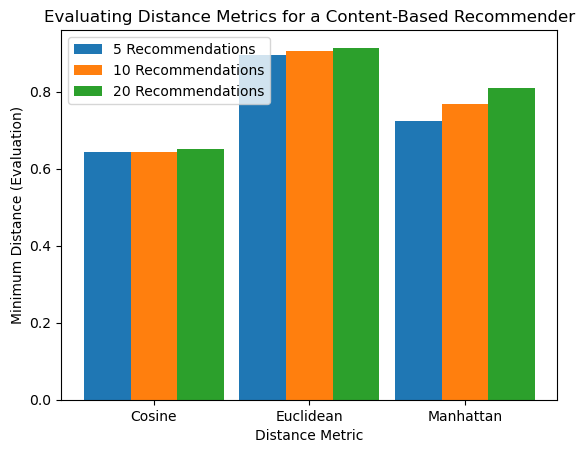

In [106]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

distance_metric_labels = ['Cosine', 'Euclidean', 'Manhattan']
num_recommendations_labels = ['5 Recommendations', '10 Recommendations', '20 Recommendations']

distance_evaluations = {
    "5": [test_recommendations['cosine'][0]['minimum_distance'], 
          test_recommendations['euclidean'][0]['minimum_distance'], 
          test_recommendations['manhattan'][0]['minimum_distance']],
    
    "10": [test_recommendations['cosine'][1]['minimum_distance'], 
          test_recommendations['euclidean'][1]['minimum_distance'], 
          test_recommendations['manhattan'][1]['minimum_distance']],
    
    "20": [test_recommendations['cosine'][2]['minimum_distance'], 
          test_recommendations['euclidean'][2]['minimum_distance'], 
          test_recommendations['manhattan'][2]['minimum_distance']]
}

bar_width = 0.3
ind = np.arange(3)
ax.bar(ind, distance_evaluations["5"], bar_width, label=num_recommendations_labels[0])
ax.bar(ind + bar_width, distance_evaluations["10"], bar_width, label=num_recommendations_labels[1])
ax.bar(ind + (bar_width * 2), distance_evaluations["20"], bar_width, label=num_recommendations_labels[2])
ax.set_ylabel('Minimum Distance (Evaluation)')
ax.set_xlabel('Distance Metric')
ax.set_title('Evaluating Distance Metrics for a Content-Based Recommender')

plt.xticks(ind + bar_width, distance_metric_labels)
plt.legend(loc='best')
plt.show()

## Evaluate the Collaborative Recommender

In [110]:
cf_svd_recommender = CollaborativeFilteringRecommender(cf_ratings_data, performGridsearch=False)

In [111]:
cf_svd_recommendations_5 = cf_svd_recommender.test_recommendations(5, test_df, anime_cbf_recommender.anime_vector_df)
print(cf_svd_recommendations_5)
cf_svd_recommendations_10 = cf_svd_recommender.test_recommendations(10, test_df, anime_cbf_recommender.anime_vector_df)
print(cf_svd_recommendations_10)
cf_svd_recommendations_20 = cf_svd_recommender.test_recommendations(20, test_df, anime_cbf_recommender.anime_vector_df)
print(cf_svd_recommendations_20)

{'minimum_distance': 0.7268898630560298}
{'minimum_distance': 0.7399363300628973}
{'minimum_distance': 0.7525884067377139}


In [112]:
cf_nmf_recommender = CollaborativeFilteringRecommender(cf_ratings_data, mf_algorithm=NMF, performGridsearch=False)

In [113]:
cf_nmf_recommendations_5 = cf_nmf_recommender.test_recommendations(5, test_df, anime_cbf_recommender.anime_vector_df)
print(cf_nmf_recommendations_5)
cf_nmf_recommendations_10 = cf_nmf_recommender.test_recommendations(10, test_df, anime_cbf_recommender.anime_vector_df)
print(cf_nmf_recommendations_10)
cf_nmf_recommendations_20 = cf_nmf_recommender.test_recommendations(20, test_df, anime_cbf_recommender.anime_vector_df)
print(cf_nmf_recommendations_20)

{'minimum_distance': 0.887519184495536}
{'minimum_distance': 0.8711138129081759}
{'minimum_distance': 0.8589106809108982}


In [ ]:
# TODO: Create a graph showing the evaluation results

## Evaluate the Hybrid Recommender

In [114]:
hybrid_recommender = HybridRecommender(anime_df, train_df)

In [115]:
hybrid_recommender_eval_5 = hybrid_recommender.test_recommendations(5, test_df)
hybrid_recommender_eval_5

{'minimum_distance': 0.7187433423182727}

In [116]:
hybrid_recommender_eval_10 = hybrid_recommender.test_recommendations(10, test_df)
hybrid_recommender_eval_10

{'minimum_distance': 0.7208690263861832}

In [117]:
hybrid_recommender_eval_20 = hybrid_recommender.test_recommendations(20, test_df)
hybrid_recommender_eval_20

{'minimum_distance': 0.7227227560700594}